# Implementing the Perceptron Algorithm

[Perceptron.py](https://github.com/leftmire/lizrightmireio.github.io/blob/main/posts/Perceptron/perceptron.py)

### Abstract

This blog is a deep dive into the perceptron algorithm -- a supervised binary classification algorithm created in 1957. This algorithm begins with a randomly generated weight vector, and then updates the weight vectors using a random data point and a score generated from the point and the current weight vector. When the loss function quantifying the discrepency between predicted values of the data and actual values is 0, the algorithm terminates and the resulting weight vector describes the decision boundary between the classes.

I begin by describing my implementation of a perceptron algorithm, and then  investigate the algorithm's effectiveness on three types of datasets: linearly separable, not linearly separable, and multi-dimensional. As expected, the algorithm is able to find the decision boundary between linearly separable classes, yet fails with not linearly separable classes. Finally, the five dimensional data I generate does not appear to be  separable via a perceptron algorithm.

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

# load contents of perceptron.py
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

### Perceptron Implementation

You can find my implementation of the perceptron algorithm at [Perceptron.py](https://github.com/leftmire/lizrightmireio.github.io/blob/main/posts/Perceptron/perceptron.py). 

Perceptron.grad first computes the score for each data point in the feature matrix. The score is the feature matrix X matrix multiplied by the weight vector.

If the score is a different sign from the actual class label, the update is computed. Else, zeros are returned -- this entry in the weight vector doesn't need to be updated.

### Experiment 1: Linearly Separable

When given linearly separable data, the perceptron algorithm should converge to a weight vector that describes a line separating the two classes of data. Let's check that this is true for our implementation of the perceptron algorithm.

First, generate linearly separable data

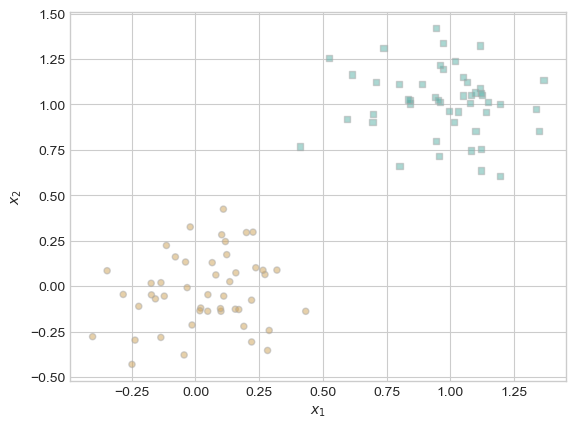

In [2]:
# import some data
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 96, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

code modified from [Prof Phil's Notes](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html#fig-demonstration)

It is easy to imagine a decision boundary that would divide these two classes.

Now, let's run the perceptron algorithm. After just 3 iterations, the loss is 0 and a dividing line is discovered.

In [3]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

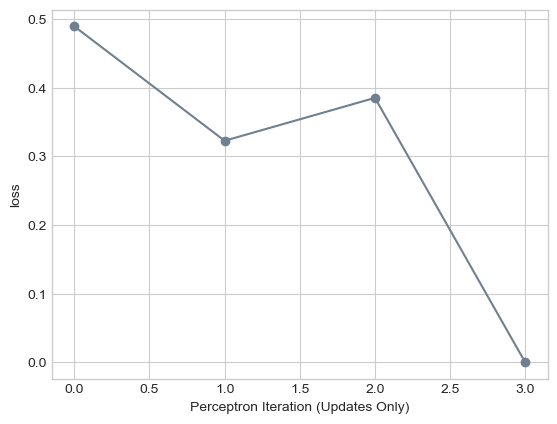

In [4]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

How did this happen? Using a simple loop, the answer to this question can be visualized on side-by-side plots. The circled point is the one randomly chosen for the perceptron update, and the line updates from the dotted line to the solid line.

In [5]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

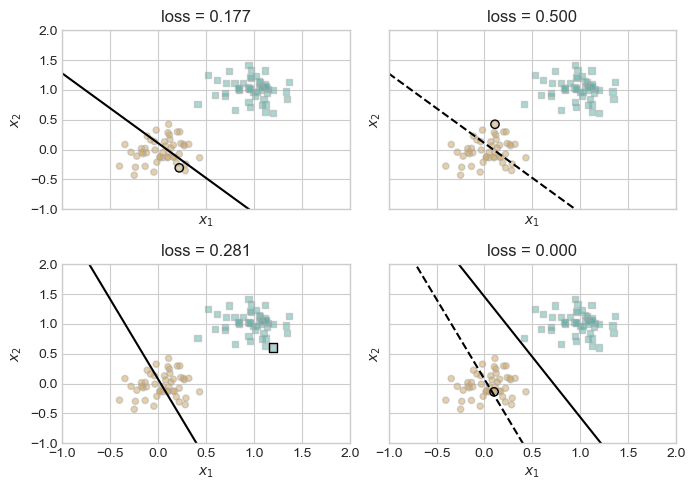

In [6]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 2, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]


    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(x_i, y_i)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))

        if(current_ax < 3):
            current_ax += 1
        else:
            break
plt.tight_layout()

visualization code modified from [Prof Phil's Notes](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html#fig-demonstration)

### Experiment 2: Not Linearly Separable

Let's generate some data that isn't linearly separable by increasing the noise of our original data

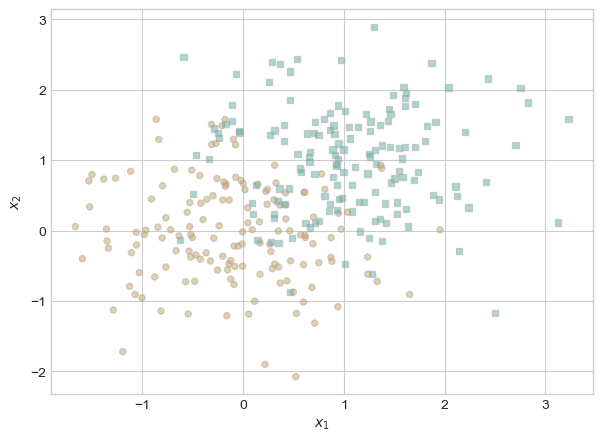

In [7]:
X_noise, y_noise = perceptron_data(n_points = 300, noise = 0.7)
fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X_noise, y_noise, ax)

Now, let's run the perceptron algorithm

In [8]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss = 1.0
iteration = 0

# for keeping track of loss values
loss_vec = []

n = X_noise.size()[0]

while loss > 0 and iteration < 1000: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X_noise, y_noise) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X_noise[[i],:]
    y_i = y_noise[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    iteration = iteration + 1

final_weights = opt.model.w

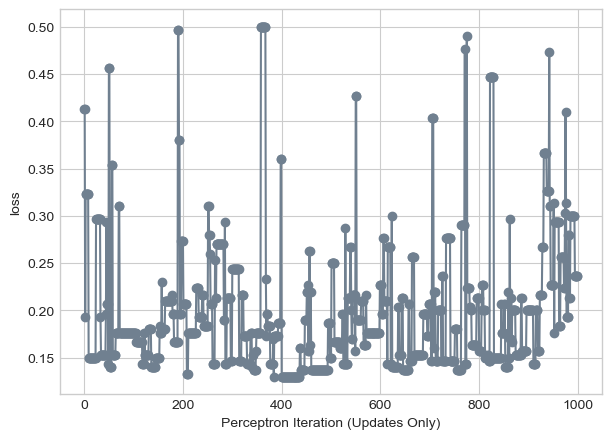

In [9]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Even with 1,000 perceptron updates, the algorithm does not terminate because the loss will never reach 0!

What dividing line does the perceptron algorithm produce, 1,000 updates later?

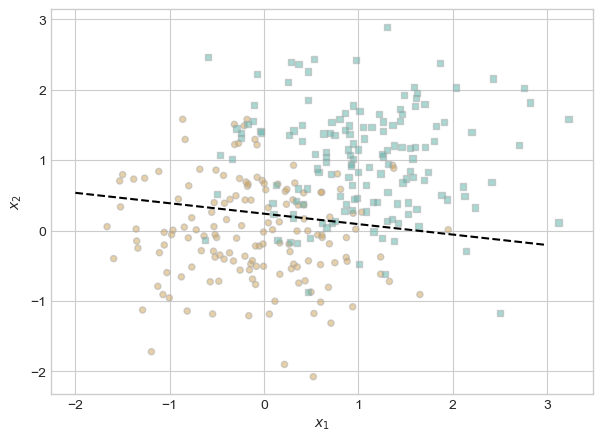

In [10]:
fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X_noise, y_noise, ax)
draw_line(final_weights, x_min = -2, x_max = 3, ax = ax, color = "black", linestyle = "dashed")

Hmm, this isn't even a very good separator. Obviously, the perceptron algorithm performs poorly on data that isn't perfect linearly separable.

### Experiment 3: Multi-Dimensional Data

The perceptron algorithm should work on data that is more than 2-dimensional.

First, geneate some five-dimensional data to experiment with.

In [11]:
def five_d_data(n_points=100, noise=0.2):
    # Generate random points in 5D space
    X = torch.randn(n_points, 5)
    y = (X[:, 0] + X[:, 1] * X[:, 2] > 0).float()

    return X, y

X_5d, y_5d = five_d_data()


Now, run the perceptron algorithm.

In [12]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss = 1.0
iteration = 0

# for keeping track of loss values
loss_vec = []

n = X_5d.size()[0]

while loss > 0 and iteration < 3000: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X_5d, y_5d) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X_5d[[i],:]
    y_i = y_5d[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    iteration = iteration + 1

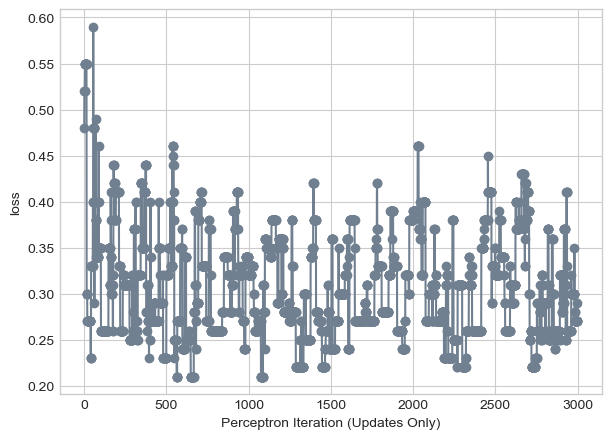

In [13]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Even after 3,000 iterations, the loss stays fairly high -- around 0.3. The loss does not appear to be consistently decreasing with each update. This leads me to believe that the data I created isn't linearly separable.

### Minibatch Perceptron Experiments

I edited my perceptron.py file to be compatable with the mini-batch perceptron algorithm, which computes an update using k points at once rathar than a single point.

Now, I will conduct experiments to explore how minibatch perceptron performs in different scenarios. First, set k = 1.

In [46]:
def plot_loss(loss):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))


    plt.plot(loss, color = "slategrey")
    plt.scatter(torch.arange(len(loss)), loss, color = "slategrey", s=5)
    labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "loss")
    
    plt.title(f"Final loss: {loss[len(loss)-1]:.3f}")

#[CITE]

In [61]:
torch.manual_seed(88)

X, y = perceptron_data()

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
loss = 1.0

# set k to 1
k = 1

# keep track of loss
loss_vec = []

n = X.size()[0]

while loss > 0:
    # random submatrix of feature matrix passed to PerceptronOptimizer.step()
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

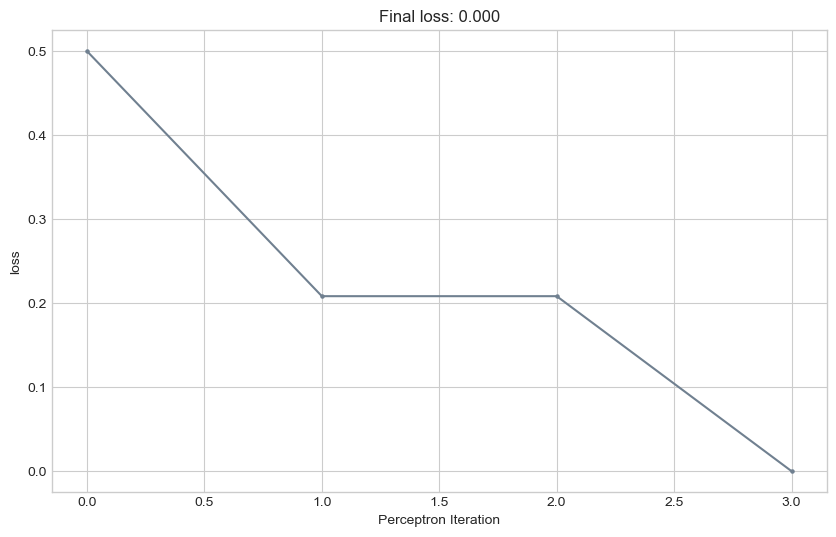

In [62]:
plot_loss(loss_vec)

With k = 1, minibatch performs similarly to the regular perceptron. The loss tends to decrease until reaching 0.

Let's try k = 10.

In [63]:
torch.manual_seed(88)

X, y = perceptron_data()

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
loss = 1.0

# set k = 10
k = 10

# keep track of loss
loss_vec = []

n = X.size()[0]

while loss > 0:
    # random submatrix of feature matrix passed to PerceptronOptimizer.step()
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

### Conclusion

The update in each iteration of the perceptron algorithm is computed as X \* w, the product between a single row of matrix X and the weight vector w. Each row in X has p entries for the p features, so this process is O(p). 

I was able to prove that the perceptron algorithm, though simple, is both effective and efficient at finding a linear classifier for data of any dimension. I wrote my first implementation of an algorithm and gained a deeper understanding of its inner workings. This knowledge will translate well when I study more complicated machine learning algorithms. 